<a id=top-page></a>

# `pykitPIV` demo: Integrate synthetic image generation with training a convolutional neural network (CNN)

In this Jupyter notebook, we show how the synthetic PIV image generation can be integrated with training the
lightweight image matching architecture (LIMA) model in one Python workflow.

For more information on kinematic training of convolutional neural networks (CNNs) using synthetic PIV/BOS images, please
check the following references:

- [Kinematic training of convolutional neural networks for particle image velocimetry](https://iopscience.iop.org/article/10.1088/1361-6501/ac8fae/meta)

- [A lightweight neural network designed for fluid velocimetry](https://link.springer.com/article/10.1007/s00348-023-03695-8)

- [A lightweight convolutional neural network to reconstruct deformation in BOS recordings](https://link.springer.com/article/10.1007/s00348-023-03618-7)


<div class="alert alert-block alert-info" style="margin-top: 20px">
<font size="3"><strong>Table of contents:</strong></font>
<br>
<ol>
    <li><a href="#synthetic-images">Generate synthetic images with <code>pykitPIV</code></a></li>
        <ul>
        <li><a href="#synthetic-images-training-set">Training set</a></li>
        <li><a href="#synthetic-images-testing-set">Testing set</a></li>
        </ul>
    <li><a href="#train-LIMA">Train LIMA with the generated images</a></li>
        <ul>
        <li><a href="#train-LIMA-input-data">Prepare input dataset generated with <code>pykitPIV</code> for LIMA</a></li>
        <li><a href="#train-LIMA-run">Run LIMA training</a></li>
        </ul>
    <li><a href="#predict">Make predictions from the trained network</a></li>
</ol>
<p></p>
</div>
<br>

***

In [1]:
import argparse
import os
import time
import pytorch_lightning as pl
import torchvision.transforms
from rich import print
from torch.utils.data import DataLoader
import lima
import glob
import h5py
import skimage.io as io
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import cmcrameri.cm as cmc
from pykitPIV import Particle, FlowField, Motion, Image
from pykitPIV import PIVDatasetPyTorch

lvpyio module is not available on macOS.


/Users/kamilazdybal/anaconda3/envs/lima-pykitPIV/lib/python3.10/site-packages/lima/__init__.py:14: UserWarning: GPU not available and could not be checked!
  warn("GPU not available and could not be checked!")
2025-05-26 18:24:49.482646: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
save_images = False
filename = None

In [3]:
figsize = (5,3)

<a id=synthetic-images></a>

***

## Generate synthetic images with `pykitPIV`

[Go to the top](#top-page)

We define the PIV image sizes $(128 \text{px} \times 128 \text{px})$
and we specify a $2 \text{px}$ buffer for the image size.
The buffer prevents particle density to artificially decrease near image boundaries due to particle movement
towards the interior of an image.
With the buffer, particles that reside within the $2 \text{px}$ outline from the boundary of image frame $I_1$
are able to enter the proper image area in image frame $I_2$.

In [4]:
image_size = (64,64)

In [5]:
size_buffer = 2

Below, we define a function for generating train and test PIV image pairs and the flow targets (velocity components $u$ and $v$).


In [24]:
def generate_images(n_images, random_seed):

    # Instantiate an object of the Particle class:
    particles = Particle(n_images,
                         size=image_size,
                         size_buffer=size_buffer,
                         diameters=1,
                         densities=0.5,
                         diameter_std=0.2,
                         seeding_mode='random',
                         dtype=np.float32,
                         random_seed=random_seed)

    # Instantiate an object of the FlowField class:
    flowfield = FlowField(n_images,
                          size=image_size,
                          size_buffer=size_buffer,
                          time_separation=1,
                          dtype=np.float32,
                          random_seed=random_seed)

    flowfield.generate_random_velocity_field(gaussian_filters=(10,11),
                                             n_gaussian_filter_iter=10,
                                             displacement=(1,2))

    # Instantiate an object of the Motion class:
    motion = Motion(particles, 
                    flowfield, 
                    particle_loss=(0,2), 
                    particle_gain='matching',
                    dtype=np.float32)

    # Instantiate an object of the Image class:
    image = Image(dtype=np.float32,
                  random_seed=random_seed)

    # Prepare images - - - - - - - - - - - - - - - - - - 

    image.add_particles(particles)

    image.add_flowfield(flowfield)
            
    motion.forward_euler(n_steps=10)
    
    image.add_motion(motion)
    
    image.add_reflected_light(exposures=0.98,
                              maximum_intensity=2**16-1,
                              laser_beam_thickness=1,
                              laser_over_exposure=1,
                              laser_beam_shape=0.95,
                              alpha=1/8)
    
    return image

<a id=synthetic-images-testing-set></a>

### Testing set

[Go to the top](#top-page)

The test set will have 10 image pairs:

In [25]:
n_images = 10

Testing dataset can be generated with a different random seed than training dataset to assure a diverse inference from the trained model.

In [26]:
test_random_seed = 200

Call the function that generates image pairs:

In [27]:
image_test = generate_images(n_images, test_random_seed)

Finally, we convert the generated images and their corresponding targets to 4-dimensional tensors:

In [28]:
images_I1 = image_test.remove_buffers(image_test.images_I1)
images_I1 = images_I1 / 65535
images_I2 = image_test.remove_buffers(image_test.images_I2)
images_I2 = images_I2 / 65535

velocity_field = image_test.remove_buffers(image_test.get_velocity_field())
displacement_field = image_test.remove_buffers(image_test.get_displacement_field())

images_intensities = image_test.concatenate_tensors((images_I1, images_I2))

tensors_dictionary_test = {"I"      : images_intensities, 
                           "targets" : displacement_field}

In [29]:
images_intensities.shape

(10, 2, 64, 64)

In [30]:
displacement_field.shape

(10, 2, 64, 64)

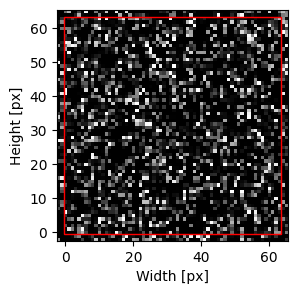

In [31]:
image_test.plot(0,
                 instance=1,
                 with_buffer=True,
                 xlabel='Width [px]',
                 ylabel='Height [px]',
                 cmap='Greys_r',
                 figsize=figsize);

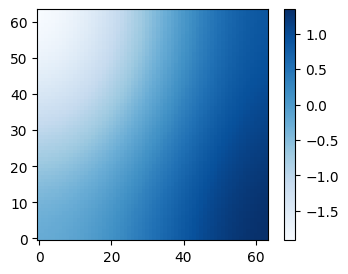

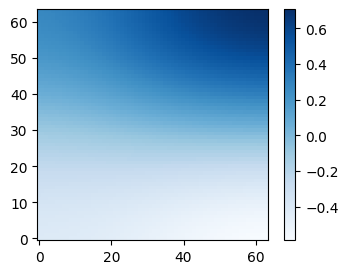

In [32]:
image_test.plot_field(0,
                       cmap='Blues',
                       cbar=True,
                       figsize=(4,3));

<a id=synthetic-images-training-set></a>

### Training set

[Go to the top](#top-page)

The training set will have 1000 image pairs:

In [33]:
n_images = 500

We fix a random seed for generating the training set of PIV images:

In [34]:
training_random_seed = 100

Call the function that generates image pairs:

In [35]:
tic = time.perf_counter()

image_train = generate_images(n_images, training_random_seed)

toc = time.perf_counter()

print(f'\tData generation time: {(toc - tic)/60:0.1f} minutes.\n' + '-'*40)

Training time: 3.6 minutes.
----------------------------------------

Finally, we convert the generated images and their corresponding targets to 4-dimensional tensors:

In [36]:
images_I1 = image_train.remove_buffers(image_train.images_I1)
images_I1 = images_I1 / 65535
images_I2 = image_train.remove_buffers(image_train.images_I2)
images_I2 = images_I2 / 65535

velocity_field = image_train.remove_buffers(image_train.get_velocity_field())
displacement_field = image_train.remove_buffers(image_train.get_displacement_field())

images_intensities = image_train.concatenate_tensors((images_I1, images_I2))

tensors_dictionary_train = {"I"      : images_intensities, 
                            "targets" : displacement_field}

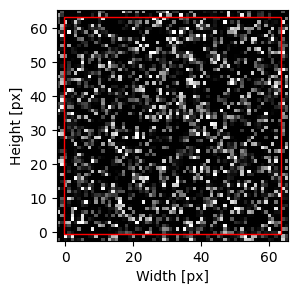

In [37]:
image_train.plot(0,
                 instance=1,
                 with_buffer=True,
                 xlabel='Width [px]',
                 ylabel='Height [px]',
                 cmap='Greys_r',
                 figsize=figsize);

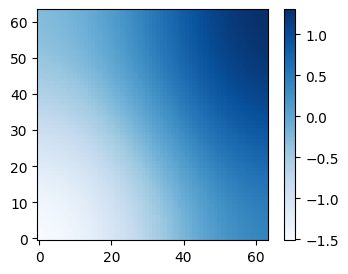

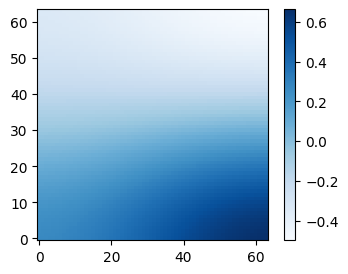

In [38]:
image_train.plot_field(0,
                       cmap='Blues',
                       cbar=True,
                       figsize=(4,3));

<a id=train-LIMA></a>
***

## Train `LIMA` with the generated images

[Go to the top](#top-page)

<a id=train-LIMA-input-data></a>
### Prepare input dataset generated with `pykitPIV` for LIMA

[Go to the top](#top-page)

In [ ]:
batch_size = 128

We use the dedicated dataset primitive using the `PIVDatasetPyTorch` class:

In [ ]:
train_dataset = PIVDatasetPyTorch(dataset=tensors_dictionary_train, transform=None)
test_dataset = PIVDatasetPyTorch(dataset=tensors_dictionary_test, transform=None)

And we create a PyTorch data loader:

In [ ]:
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=1,
                          pin_memory=True)

test_loader = DataLoader(test_dataset,
                         batch_size=batch_size,
                         shuffle=True)

<a id=train-LIMA-run></a>
### Run LIMA training

[Go to the top](#top-page)

In [ ]:
random_seed = 100

In [ ]:
pl.seed_everything(random_seed, workers=True)

In [ ]:
len_train_loader = len(train_loader)

Define the LIMA model:

In [ ]:
div_flow = 0.05
loss_weights = [0.32, 0.08, 0.02, 0.01, 0.005, 0.0025, 0.00125]
search_range = 2
num_chs = [1, 16, 32, 64, 96, 128, 196]
num_chs = [1, 16, 32]
output_level = 4
loss = 'l1_loss'
loss_weights_order = 'inc'
loss_J = 'abs'
loss_J_gamma = 1e-1
full_res = False
full_res_loss_weight_multiplier = 2.0
n_epochs = 50
padding_mode = 'replicate'

In [ ]:
model = lima.LIMA(div_flow=div_flow,
                  loss_weights=loss_weights,
                  search_range=search_range,
                  num_chs=num_chs,
                  output_level=output_level,
                  loss=loss,
                  loss_weights_order=loss_weights_order,
                  loss_J=loss_J,
                  loss_J_gamma=loss_J_gamma,
                  full_res=full_res,
                  full_res_loss_weight_multiplier=full_res_loss_weight_multiplier,
                  epochs=n_epochs,
                  optimizer='Adam',
                  padding_mode=padding_mode,
                  base_lr=0.001,
                  weight_decay=4e-4,
                  momentum=0.9,
                  num_workers=20,
                  beta=0.999,
                  reduction="sum",
                  scheduler='ReduceLROnPlateau',
                  lr_decay=0.2,
                  patience=5)

In [ ]:
trainer = pl.Trainer(max_epochs=n_epochs)

In [ ]:
tic = time.perf_counter()

trainer.fit(model,
            train_loader,
            test_loader)

toc = time.perf_counter()

print(f'\tTraining time: {(toc - tic)/60:0.1f} minutes.\n' + '-'*40)

<a id=predict></a>
***

## Make predictions from the trained network

[Go to the top](#top-page)

### Test data within training distribution

[Go to the top](#top-page)

In [ ]:
image_to_show = 1

Ground truth displacement fields:

In [ ]:
ground_truth_ds = tensors_dictionary_test["targets"]
ground_truth_I = tensors_dictionary_test["I"]

In [ ]:
ground_truth_ds_magnitude = np.sqrt(ground_truth_ds[:,0,:,:]**2 + ground_truth_ds[:,1,:,:]**2)

Predicted displacement fields:

In [ ]:
model.eval()
with torch.no_grad():
    predicted_ds = model(torch.from_numpy(ground_truth_I).to(dtype=torch.float)).numpy()

In [ ]:
predicted_ds_magnitude = np.sqrt(predicted_ds[:,0,:,:]**2 + predicted_ds[:,1,:,:]**2)

Compute the error of this prediction:

In [ ]:
error_dx = np.abs(ground_truth_ds[image_to_show, 0, :, :] - predicted_ds[image_to_show, 0, :, :])

In [ ]:
error_dy = np.abs(ground_truth_ds[image_to_show, 1, :, :] - -predicted_ds[image_to_show, 1, :, :])

In [ ]:
error_ds = np.abs(ground_truth_ds_magnitude[image_to_show, :, :] - predicted_ds_magnitude[image_to_show, :, :])

In [ ]:
figure = plt.figure(figsize=(13, 10))
spec = figure.add_gridspec(ncols=3, nrows=3, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1])

cmap = cmc.oslo

# Displacement in the x-direction:

figure_a = figure.add_subplot(spec[0,0])
plt.imshow(ground_truth_ds[image_to_show, 0, :, :], 
           cmap=cmap, 
           origin='lower')
plt.colorbar()
plt.title('True $dx$')

figure_b = figure.add_subplot(spec[0,1])
plt.imshow(predicted_ds[image_to_show, 0, :, :], 
           cmap=cmap, 
           origin='lower',
           vmin=np.min(ground_truth_ds[image_to_show, 0, :, :]),
           vmax=np.max(ground_truth_ds[image_to_show, 0, :, :]))
plt.colorbar()
plt.title('Predicted $dx$')

figure_c = figure.add_subplot(spec[0,2])
plt.imshow(error_dx, 
           cmap='Reds', 
           origin='lower')
plt.colorbar()
plt.title('Relative error in $dx$')

# Displacement in the y-direction:

figure_d = figure.add_subplot(spec[1,0])
plt.imshow(ground_truth_ds[image_to_show, 1, :, :], 
           cmap=cmap, 
           origin='lower')
plt.colorbar()
plt.title('True $dy$')

figure_e = figure.add_subplot(spec[1,1])
plt.imshow(-predicted_ds[image_to_show, 1, :, :], 
           cmap=cmap, 
           origin='lower', )
           # vmin=np.min(ground_truth_ds[image_to_show, 1, :, :]),
           # vmax=np.max(ground_truth_ds[image_to_show, 1, :, :]))
plt.colorbar()
plt.title('Predicted $dy$')

figure_f = figure.add_subplot(spec[1,2])
plt.imshow(error_dy, 
           cmap='Reds', 
           origin='lower')
plt.colorbar()
plt.title('Relative error in $dy$')

# Displacement magnitude:

figure_g = figure.add_subplot(spec[2,0])
plt.imshow(ground_truth_ds_magnitude[image_to_show, :, :], 
           cmap=cmap, 
           origin='lower')
plt.colorbar()
plt.title('True $|ds|$')

figure_h = figure.add_subplot(spec[2,1])
plt.imshow(predicted_ds_magnitude[image_to_show, :, :], 
           cmap=cmap, 
           origin='lower',
           vmin=np.min(ground_truth_ds_magnitude[image_to_show, :, :]),
           vmax=np.max(ground_truth_ds_magnitude[image_to_show, :, :]))
plt.colorbar()
plt.title('Predicted $|ds|$')

figure_i = figure.add_subplot(spec[2,2])
plt.imshow(error_ds, 
           cmap='Reds', 
           origin='lower')
plt.colorbar()
plt.title('Relative error in $|ds|$');

### Test data outside the training distribution

[Go to the top](#top-page)

In [ ]:
def generate_images_checkered(n_images, random_seed):

    # Instantiate an object of the Particle class:
    particles = Particle(n_images,
                         size=image_size,
                         size_buffer=size_buffer,
                         diameters=2,
                         densities=0.1,
                         diameter_std=0.2,
                         seeding_mode='random',
                         random_seed=random_seed)

    # Instantiate an object of the FlowField class:
    flowfield = FlowField(n_images,
                          size=image_size,
                          size_buffer=size_buffer,
                          time_separation=1,
                          random_seed=random_seed)

    # Generate checkered velocity field:
    flowfield.generate_checkered_velocity_field(displacement=(1, 2),
                                                m=3,
                                                n=3,
                                                rotation=10)

    # Instantiate an object of the Motion class:
    motion = Motion(particles, 
                    flowfield, 
                    particle_loss=(0,2), 
                    particle_gain='matching')

    # Instantiate an object of the Image class:
    image = Image(random_seed=random_seed)

    # Prepare images - - - - - - - - - - - - - - - - - - 

    image.add_particles(particles)

    image.add_flowfield(flowfield)
            
    motion.forward_euler(n_steps=10)
    
    image.add_motion(motion)
    
    image.add_reflected_light(exposures=(0.9,0.99),
                              maximum_intensity=2**16-1,
                              laser_beam_thickness=1,
                              laser_over_exposure=1,
                              laser_beam_shape=0.95,
                              alpha=1/8)
    
    return image

The test set will have 10 image pairs:

In [ ]:
n_images = 10

Testing dataset can be generated with a different random seed than training dataset to assure a diverse inference from the trained model.

In [ ]:
test_random_seed = 200

Call the function that generates image pairs:

In [ ]:
image_test = generate_images_checkered(n_images, test_random_seed)

Finally, we convert the generated images and their corresponding targets to 4-dimensional tensors:

In [ ]:
images_I1 = image_test.remove_buffers(image_test.images_I1)
images_I1 = images_I1 / 65535
images_I2 = image_test.remove_buffers(image_test.images_I2)
images_I2 = images_I2 / 65535

velocity_field = image_test.remove_buffers(image_test.get_velocity_field())
displacement_field = image_test.remove_buffers(image_test.get_displacement_field())

images_intensities = image_test.concatenate_tensors((images_I1, images_I2))

tensors_dictionary_test = {"I"      : images_intensities, 
                           "targets" : displacement_field}

In [ ]:
images_intensities.shape

In [ ]:
displacement_field.shape

In [ ]:
image_train.plot(0,
                 instance=1,
                 with_buffer=True,
                 xlabel='Width [px]',
                 ylabel='Height [px]',
                 cmap='Greys_r',
                 figsize=figsize);

In [ ]:
image_test.plot_field(0,
                       cmap='Blues',
                       cbar=True,
                       figsize=(4,3));

In [ ]:
image_to_show = 1

Ground truth displacement fields:

In [ ]:
ground_truth_ds = tensors_dictionary_test["targets"]
ground_truth_I = tensors_dictionary_test["I"]

In [ ]:
ground_truth_ds_magnitude = np.sqrt(ground_truth_ds[:,0,:,:]**2 + ground_truth_ds[:,1,:,:]**2)

Predicted displacement fields:

In [ ]:
model.eval()
with torch.no_grad():
    predicted_ds = model(torch.from_numpy(ground_truth_I).to(dtype=torch.float)).numpy()

In [ ]:
predicted_ds_magnitude = np.sqrt(predicted_ds[:,0,:,:]**2 + predicted_ds[:,1,:,:]**2)

Compute the error of this prediction:

In [ ]:
error_dx = np.abs(ground_truth_ds[image_to_show, 0, :, :] - predicted_ds[image_to_show, 0, :, :])

In [ ]:
error_dy = np.abs(ground_truth_ds[image_to_show, 1, :, :] - -predicted_ds[image_to_show, 1, :, :])

In [ ]:
error_ds = np.abs(ground_truth_ds_magnitude[image_to_show, :, :] - predicted_ds_magnitude[image_to_show, :, :])

In [ ]:
figure = plt.figure(figsize=(13, 10))
spec = figure.add_gridspec(ncols=3, nrows=3, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1])

cmap = cmc.oslo

# Displacement in the x-direction:

figure_a = figure.add_subplot(spec[0,0])
plt.imshow(ground_truth_ds[image_to_show, 0, :, :], 
           cmap=cmap, 
           origin='lower')
plt.colorbar()
plt.title('True $dx$')

figure_b = figure.add_subplot(spec[0,1])
plt.imshow(predicted_ds[image_to_show, 0, :, :], 
           cmap=cmap, 
           origin='lower', )
           # vmin=np.min(ground_truth_ds[image_to_show, 0, :, :]),
           # vmax=np.max(ground_truth_ds[image_to_show, 0, :, :]))
plt.colorbar()
plt.title('Predicted $dx$')

figure_c = figure.add_subplot(spec[0,2])
plt.imshow(error_dx, 
           cmap='coolwarm', 
           origin='lower')
plt.colorbar()
plt.title('Relative error in $dx$')

# Displacement in the y-direction:

figure_d = figure.add_subplot(spec[1,0])
plt.imshow(ground_truth_ds[image_to_show, 1, :, :], 
           cmap=cmap, 
           origin='lower')
plt.colorbar()
plt.title('True $dy$')

figure_e = figure.add_subplot(spec[1,1])
plt.imshow(-predicted_ds[image_to_show, 1, :, :], 
           cmap=cmap, 
           origin='lower', )
           # vmin=np.min(ground_truth_ds[image_to_show, 1, :, :]),
           # vmax=np.max(ground_truth_ds[image_to_show, 1, :, :]))
plt.colorbar()
plt.title('Predicted $dy$')

figure_f = figure.add_subplot(spec[1,2])
plt.imshow(error_dy, 
           cmap='coolwarm', 
           origin='lower')
plt.colorbar()
plt.title('Relative error in $dy$')

# Displacement magnitude:

figure_g = figure.add_subplot(spec[2,0])
plt.imshow(ground_truth_ds_magnitude[image_to_show, :, :], 
           cmap=cmap, 
           origin='lower')
plt.colorbar()
plt.title('True $|ds|$')

figure_h = figure.add_subplot(spec[2,1])
plt.imshow(predicted_ds_magnitude[image_to_show, :, :], 
           cmap=cmap, 
           origin='lower', )
           # vmin=np.min(ground_truth_ds_magnitude[image_to_show, :, :]),
           # vmax=np.max(ground_truth_ds_magnitude[image_to_show, :, :]))
plt.colorbar()
plt.title('Predicted $|ds|$')

figure_i = figure.add_subplot(spec[2,2])
plt.imshow(error_ds, 
           cmap='coolwarm', 
           origin='lower')
plt.colorbar()
plt.title('Relative error in $|ds|$');

***

© K. Zdybał, C. Mucignat, S. Kunz, I. Lunati (2025)